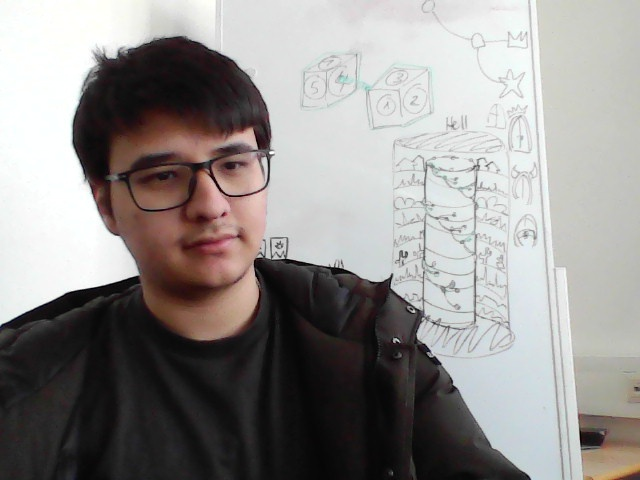

5
5
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
5
5
5
5
2
2
2
2
2
2
5
5
5
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [23]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import serial
import time

# Serial to ESP32
try:
    ser = serial.Serial('COM3', 115200, timeout=0.5)
except Exception as e:
    ser = None
    print(f"Could not open serial port: {e}")

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    # Skip if not IPython
    pass

from IPython.display import display, Image, clear_output
import time

from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
mp.__version__

model_path = 'C:/Users/mikhail/OneDrive/Documents/STEM 3/gesture_recognizer.task'

base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.GestureRecognizerOptions(base_options=base_options, num_hands=2)
recognizer = vision.GestureRecognizer.create_from_options(options)


MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (255, 255, 255)  # white

# Draw hand landmarks
def draw_landmarks_on_image(rgb_image, detection_result):
    gesture_text = detection_result.gestures[0][0].category_name if detection_result.gestures else "No Gesture"
    hand_landmarks_list = detection_result.hand_landmarks
    handedness_list = detection_result.handedness
    annotated_image = np.copy(rgb_image)
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]
        handedness = handedness_list[idx]
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
          annotated_image,
          hand_landmarks_proto,
          solutions.hands.HAND_CONNECTIONS,
          solutions.drawing_styles.get_default_hand_landmarks_style(),
          solutions.drawing_styles.get_default_hand_connections_style())
    return annotated_image

import sys
# Gesture name to ID
GESTURE_TO_NUMBER = {
    "Open_Palm": 1,
    "Closed_Fist": 2,
    "Pointing_Up": 3,
    "Victory": 4,
}

# Next gesture ID
_NEXT_GESTURE_ID = max(GESTURE_TO_NUMBER.values()) + 1

def _get_or_assign_gesture_number(name: str) -> int:
    """Get or assign gesture ID."""
    global _NEXT_GESTURE_ID
    if name in GESTURE_TO_NUMBER:
        return GESTURE_TO_NUMBER[name]
    # Assign new ID
    GESTURE_TO_NUMBER[name] = _NEXT_GESTURE_ID
    _NEXT_GESTURE_ID += 1
    return GESTURE_TO_NUMBER[name]


def on_gesture_detected_number(num, gesture_name=None, hand_index=0, score=None):
    """Print gesture number."""
    try:
        sys.stdout.write(f"{num}\n")
        sys.stdout.flush()
    except Exception:
        # Fallback to print
        print(num)


def process_recognition_result(recognition_result, annotated_image=None, target_gestures=None):
    """Process recognition, return detections."""
    detected = []
    hand_gestures_list = getattr(recognition_result, "gestures", []) or []

    for i, hand_gestures in enumerate(hand_gestures_list):
        if not hand_gestures:
            continue
        top = hand_gestures[0].category_name
        score = getattr(hand_gestures[0], "score", None)

        if (target_gestures is None) or (top in target_gestures):
            # Assign ID if unseen
            num = _get_or_assign_gesture_number(top)
            on_gesture_detected_number(num, top, i, score)
            detected.append((i, top, score, num))

        if annotated_image is not None:
            # Label near hand
            try:
                hand_landmarks = recognition_result.hand_landmarks[i]
                h, w, _ = annotated_image.shape
                x_coords = [lm.x for lm in hand_landmarks]
                y_coords = [lm.y for lm in hand_landmarks]
                text_x = int(min(x_coords) * w)
                text_y = int(min(y_coords) * h) - 10
            except Exception:
                text_x, text_y = 10, 30 + 30 * i
            cv2.putText(annotated_image, f"{_get_or_assign_gesture_number(top)}", (text_x, text_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    return annotated_image, detected

# Filter implementations
def filter_grayscale(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)

def filter_gaussian(img, k=15):
    return cv2.GaussianBlur(img, (k, k), sigmaX=3)

def filter_dilate(img, kernel_size=5, iterations=2):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    d = cv2.dilate(th, kernel, iterations=iterations)
    return cv2.cvtColor(d, cv2.COLOR_GRAY2BGR)

def filter_connected_components(img):
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th, connectivity=8)
    vis = np.zeros_like(img)
    for label_idx in range(1, num_labels):
        mask = labels == label_idx
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)
        vis[mask] = color
    return vis

def apply_filter_by_gesture_number(num, img):
    """Apply filter by ID."""
    if num == GESTURE_TO_NUMBER.get("Open_Palm"):
        return filter_grayscale(img)
    if num == GESTURE_TO_NUMBER.get("Closed_Fist"):
        return filter_gaussian(img)
    if num == GESTURE_TO_NUMBER.get("Pointing_Up"):
        return filter_connected_components(img)
    if num == GESTURE_TO_NUMBER.get("Victory"):
        return filter_dilate(img)
    return img

# Main webcam loop
from IPython.display import display, clear_output, Image

video_output = None

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Cannot open webcam (VideoCapture(0) failed)")

start = time.time()
frame_count = 0

# Latch: 5 sec
last_gesture = None
last_gesture_time = 0
LATCH_DURATION = 5.0  # sec

# Both open: 7 sec
special_freeze = False
special_freeze_start = 0
SPECIAL_DURATION = 7.0  # sec
frozen_frame = None

# Pick best score
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        timestamp_ms = int((time.time() - start) * 1000)
        # BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)
        recognition_result = recognizer.recognize(mp_image)

        annotated_image = draw_landmarks_on_image(frame, recognition_result)
        # Process gestures
        annotated_image, detected = process_recognition_result(recognition_result, annotated_image=annotated_image, target_gestures=None)

        # Both hands open?
        both_open = False
        if len(detected) >= 2:
            open_count = sum(1 for _, name, _, _ in detected if name == "Open_Palm")
            if open_count >= 2:
                both_open = True

        now = time.time()
        # Special freeze first
        if special_freeze:
            if (now - special_freeze_start) >= SPECIAL_DURATION:
                # Expired
                special_freeze = False
                frozen_frame = None
            else:
                # In freeze
                frame_to_show = frozen_frame
                # Encode display
                _, buf = cv2.imencode('.jpg', frame_to_show)
                img = Image(data=buf.tobytes())
                if video_output is None:
                    video_output = display(img, display_id="video")
                else:
                    video_output.update(img)
                frame_count += 1
                time.sleep(0.03)
                continue

        # Trigger if both
        filter_active = last_gesture is not None and (now - last_gesture_time) < LATCH_DURATION
        if both_open and not filter_active and not special_freeze:
            # Grayscale overlay
            frozen_frame = filter_grayscale(annotated_image.copy())
            h, w, _ = frozen_frame.shape
            bar_height = max(40, int(0.12 * h))
            # Bar on top
            cv2.rectangle(frozen_frame, (0, 0), (w, bar_height), (255, 255, 255), -1)
            # Centered text
            text = "absolute cinema"
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_scale = 1.2
            text_thickness = 2
            (text_w, text_h), _ = cv2.getTextSize(text, font, text_scale, text_thickness)
            text_x = (w - text_w) // 2
            text_y = (bar_height + text_h) // 2 + 4
            cv2.putText(frozen_frame, text, (text_x, text_y), font, text_scale, (0, 0, 0), text_thickness, cv2.LINE_AA)

            special_freeze = True
            special_freeze_start = now
            # Show frozen
            frame_to_show = frozen_frame
            _, buf = cv2.imencode('.jpg', frame_to_show)
            img = Image(data=buf.tobytes())
            if video_output is None:
                video_output = display(img, display_id="video")
            else:
                video_output.update(img)
            frame_count += 1
            time.sleep(0.03)
            continue

        # Gesture latch
        if filter_active:
            # Locked active
            pass
        else:
            # Not active
            if last_gesture is not None:
                # Clear
                last_gesture = None

            if detected:
                # Best score
                best = max(detected, key=lambda x: (x[2] if x[2] is not None else 0))
                _, gesture_name, score, num = best
                # Trust recognizer
                last_gesture = num
                last_gesture_time = now
                filter_active = True

                # Send to ESP32
                try:
                    if ser is not None:
                        ser.write(f"{num}\n".encode())
                        ser.flush()
                except Exception as e:
                    pass

        # Apply filter
        if filter_active and last_gesture is not None:
            try:
                frame_to_show = apply_filter_by_gesture_number(last_gesture, annotated_image.copy())
            except Exception as e:
                frame_to_show = annotated_image
        else:
            frame_to_show = annotated_image

        # Encode JPEG
        _, buf = cv2.imencode('.jpg', frame_to_show)
        img = Image(data=buf.tobytes())
        # Update display
        if video_output is None:
            video_output = display(img, display_id="video")
        else:
            video_output.update(img)
        frame_count += 1
        time.sleep(0.03)  # 30 FPS
except KeyboardInterrupt:
    # Stop on Ctrl+C
    pass
finally:
    cap.release()
    if ser is not None:
        try:
            ser.close()
        except:
            pass
    sys.stdout.write(f"Processed {frame_count} frames.\n")
    sys.stdout.flush()